In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

## Functions

In [68]:
def drop_vars(df):
    columns_to_drop = [
        # Those we want to remove for all analyses
        'Date','Vodka Sold PC','Gin Sold PC', 'Rum Sold PC', 'Whiskey Sold PC', 'Tequila Sold PC', 'Other Alc Sold PC',
        'Gin Sold PROP','Rum Sold PROP','Whiskey Sold PROP','Tequila Sold PROP','Other Alc Sold PROP','Vodka Sold PROP',
        # Remove linearly dependent columns
        'is_weekend', 'Young Prop', 'LowIncome Prop', 'Other Prop',
        # remove target columns
        'Volume Sold PC', 'Bottles Sold PC', 'Sales Volume PC']
    df = df.drop(columns_to_drop, axis = 1)
    return df


# specify what columns to make dummies for 
def make_dummies(df, columns):
    new_cols = []
    for col in columns:
        if col == 'Year':
            # get dummies for year 
            year_dummies = pd.get_dummies(df['Year'], drop_first = True)
            year_dummies.columns = ["year_" + str(column) for column in year_dummies.columns]
            new_cols.append(year_dummies)
            df = df.drop(['Year'], axis = 1)
        elif col == 'Month':
            # get dummies for month
            month_dummies = pd.get_dummies(df['Month'], drop_first = True)
            month_dummies.columns = ["month_" + str(column) for column in month_dummies.columns]
            new_cols.append(month_dummies)
            df = df.drop(['Month'], axis = 1)
        elif col == 'County':
            # get dummies for county
            county_dummies = pd.get_dummies(df['County'], drop_first = True)
            new_cols.append(county_dummies)
            df = df.drop(['County'], axis = 1)
        elif col == 'DOW':
            dow_dummies = pd.get_dummies(df['DOW'], drop_first = True)
            new_cols.append(dow_dummies)
            df = df.drop(['DOW'], axis = 1)
            
    full_set = [df]+new_cols
    df = pd.concat(full_set, axis = 1)
    return df


def get_intermediate_matrix(df, response_df, numeric_columns, standardize=True):
    
    
    # if there are numeric columns:
    if numeric_columns is not None and standardize is True:
        non_numeric_columns = [column for column in df.columns if column not in numeric_columns]
        # standard scale non categorical columns
        ct = make_column_transformer(
                (StandardScaler(), numeric_columns)
                , remainder='passthrough')
        ct_array = ct.fit_transform(df)
        column_order = ['Intercept'] + numeric_columns + non_numeric_columns
        x_mat = np.asmatrix(ct_array) 
    # only categorical columns
    else:
        non_numeric_columns = [column for column in df.columns]
        column_order = ['Intercept'] + non_numeric_columns
        x_mat = np.asmatrix(df)   
        
    intercept_array = np.ones((x_mat.shape[0], 1))
    x_mat = np.concatenate((intercept_array, x_mat),1)
    response_mat = np.asmatrix(response_df).getT()
    
    matrix_without_target = x_mat
    matrix_with_target = np.concatenate((response_mat, x_mat), 1)
    return matrix_with_target, matrix_without_target, response_mat, column_order


def get_betas(x_mat, response_mat, reg_type, lambda_val=100):
    if reg_type == 'OLS':
        # ols beta estimates
        betas = np.matmul(np.matmul(np.matmul(x_mat.getT(), x_mat).getI(), x_mat.getT()), response_mat)
    elif reg_type == 'Ridge':
        lambda_mat = np.diag(np.full(x_mat.shape[1], lambda_val))
        betas = np.matmul(np.matmul((np.matmul(x_mat.getT(), x_mat)+lambda_mat).getI(), x_mat.getT()), response_mat)
    return betas


def show_beta_summary(betas, column_order):
    return pd.DataFrame({'Variable' : column_order, 'Coefficient' : betas.A1}).sort_values(by = 'Coefficient', ascending = False)

In [48]:
def run_cross_val(data, k, penalty="OLS", lam=100):
    # shuffle matrix
    np.random.shuffle(data)
    k_splits = np.array_split(data, k)
    r2_list = []
    rmse_list = []
    metrics = {}
    for i in range(k):
        # Get train/validation split
        validate = k_splits[i]
        train = np.concatenate([k_splits[j] for j in range(k) if j != i])
        
        y_train = train[:, 0]
        x_train = train[:, 1:]
        
        y_val = validate[:,0]
        x_val = validate[:, 1:]
        # Train the model on the training data
        if penalty == "OLS":
            # ols beta estimates
            betas = np.matmul(np.matmul(np.matmul(x_train.getT(), x_train).getI(), x_train.getT()), y_train)
        elif penalty == "Ridge":
            # make diagonal matrix for lambda
            lambda_mat = np.diag(np.full(x_train.shape[1], lam))
            # ols beta estimates
            betas = np.matmul(np.matmul((np.matmul(x_train.getT(), x_train)+lambda_mat).getI(), x_train.getT()), y_train)
        else:
            raise ValueError("not a recognizable penalty")
        
        # Make predictions on validation data
        y_pred = np.matmul(x_val, betas)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_list.append(rmse)
        r2 = r2_score(y_val, y_pred)
        r2_list.append(r2)
        
    metrics['avg r_2'] = np.mean(r2_list)
    metrics['avg rmse'] = np.mean(rmse_list)
    
    return metrics

In [49]:
# prepare the df to plot RMSE/lambda
def roc_df(matrix, lambda_list, k):
    df = {'Lambda': [], 'Avg. RMSE': []}
    for l in lambda_list:
        # print('Working on lambda {}'.format(l))
        metrics = run_cross_val(matrix, k, "Ridge")
        df['Lambda'].append(l)
        df['Avg. RMSE'].append(metrics['avg rmse'])
    return pd.DataFrame(df)

## Reading in Dataset

In [23]:
# reading in raw data
raw_df = pd.read_csv("harlech_data_proportions.csv", low_memory = False)

## Train Dev Test Split

In [40]:
# pulling out response variables
response_df = raw_df[['Volume Sold PC', 'Bottles Sold PC', 'Sales Volume PC']]
# dropping the variables we are currently not using
df = drop_vars(raw_df)
# 0.1 test split 
X_train, X_test, y_train, y_test = train_test_split(df, response_df, test_size=0.1, random_state=420)

# *** DO NOT TOUCH X_TEST AND Y_TEST UNTIL THE VERY END *** 
- I set a random state already, so results should be consistent

In [60]:
# X_train X_test, y_train, y_test are all regular dfs
X_train.head()

,County,Year,Poverty,Population,DOW,Month,White Prop,Black Prop,Native American Prop,Asian Prop,Pacific Prop,Two+ Prop,HighIncome Prop,MidIncome Prop,Middle-Old Prop,Middle-Young Prop,Old Prop
18073,O'BRIEN,2014,7.3,14045.0,Tuesday,2,0.947985,0.005109,0.002058,0.008445,0.000142,0.012347,0.128670,0.659689,0.295180,0.218584,0.364049
50415,IOWA,2018,8.4,16150.0,Monday,12,0.959950,0.005509,0.000248,0.003776,0.000000,0.027050,0.205333,0.630667,0.283241,0.231381,0.352249
59342,BLACK HAWK,2019,15.5,131089.0,Tuesday,12,0.830555,0.096151,0.003968,0.026993,0.002784,0.028836,0.209806,0.543299,0.226826,0.241214,0.319122
30060,BOONE,2015,10.1,26468.0,Tuesday,9,0.971857,0.008901,0.002045,0.003220,0.000379,0.012462,0.145129,0.643683,0.293791,0.245383,0.324965
17082,LINN,2013,9.8,216567.0,Monday,12,0.897466,0.042222,0.002433,0.019862,0.000152,0.028476,0.211278,0.585274,0.280189,0.277637,0.275762


In [61]:
y_train.head()

,Volume Sold PC,Bottles Sold PC,Sales Volume PC
18073,0.178702,0.146315,1.822865
50415,0.061034,0.061300,0.760484
59342,0.156045,0.240005,2.845622
30060,0.009056,0.008425,0.139549
17082,0.016383,0.018766,0.260010


# Predictive Model

In [41]:
# numeric columns for the current full predictive model
numeric_columns = ['Poverty ', 'Population', 'White Prop', 'Black Prop',
                    'Native American Prop', 'Asian Prop', 'Pacific Prop', 'Two+ Prop',
                    'HighIncome Prop', 'MidIncome Prop', 'Middle-Old Prop','Middle-Young Prop', 'Old Prop']

## Sales Volume PC

In [44]:
X_train.columns

Index(['County', 'Year', 'Poverty ', 'Population', 'DOW', 'Month',
       'White Prop', 'Black Prop', 'Native American Prop', 'Asian Prop',
       'Pacific Prop', 'Two+ Prop', 'HighIncome Prop', 'MidIncome Prop',
       'Middle-Old Prop', 'Middle-Young Prop', 'Old Prop'],
      dtype='object')

In [69]:
# drop county because it's confounding
X_train_no_county = X_train.drop(columns=['County'])
# making dummies, indicate in argument what columns to dummify
df_sv = make_dummies(X_train_no_county, ['DOW', 'Month', 'Year'])

# get all the matrices needed for cross val
# passes in the df with dummies, the response var, and all the numeric columns of interest for standard scaling
sv_mat_with, sv_mat_without, sv_response_mat, sv_col_order = get_intermediate_matrix(df_sv, 
                                                                                     y_train['Sales Volume PC'], 
                                                                                     numeric_columns, 
                                                                                     True)

### OLS

In [70]:
# run cross val
# 5 folds
# OLS, returns avg r2 and rmse
run_cross_val(sv_mat_with, 5, "OLS")

{'avg r_2': 0.10973250935939496, 'avg rmse': 0.7264859796836858}

### Ridge

In [71]:
# same thing but with ridge
run_cross_val(sv_mat_with, 5, "Ridge", 100)

{'avg r_2': 0.10923167409164936, 'avg rmse': 0.7267638434035582}

<AxesSubplot:xlabel='Lambda'>

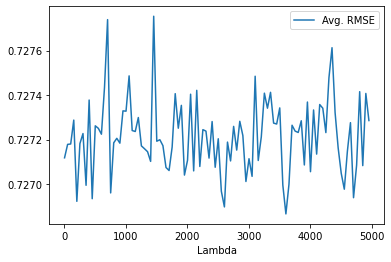

In [65]:
range_test = np.arange(1,5000,50)
roc = roc_df(sv_mat_with, range_test, 2)
roc.plot.line(x='Lambda', y='Avg. RMSE')

## Example where I don't standardize numeric columns

In [72]:
sv_mat_with, sv_mat_without, sv_response_mat, sv_col_order = get_intermediate_matrix(df_sv, 
                                                                                     y_train['Sales Volume PC'], 
                                                                                     numeric_columns, 
                                                                                     False) # make this flag False to not standard for OLS
run_cross_val(sv_mat_with, 5, "OLS")

{'avg r_2': 0.10937184964729714, 'avg rmse': 0.7265201154877021}

# Subset of Variables Example

## Bottles Sold PC

In [66]:
# choosing variables of interest
subset_example = X_train[['County', 'Month', 'Year', 'DOW']]
# make dummies
subset_bs = make_dummies(subset_example, ['County','DOW', 'Month', 'Year'])

# get matrices
# THERE ARE NO NUMERIC COLUMNS SO I PASS IN NONE FOR THAT ARGUMENT
bs_mat_with, bs_mat_without, bs_response_mat, bs_col_order = get_intermediate_matrix(subset_bs, y_train['Bottles Sold PC'], None)

In [67]:
run_cross_val(bs_mat_with, 5, "OLS")

{'avg r_2': 0.3200280211924281, 'avg rmse': 0.04573994005209235}